# Compare humidity and sea ice's impact

Author: Ziqi Yin

Last modified: 2024 Jul 25

Table of contents:
* [Time series of summer (JJA) and winter (DJF) mean GrIS-averaged 2m air temperature, relative and specific humidity](#first-bullet)
* [Maps of ](#second-bullet)

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from scipy import interpolate
from scipy import stats
import scipy.signal as sig #for filtering

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
crs_ortho = ccrs.Orthographic(central_longitude=0, central_latitude=90)
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import geocat.comp as gc #to interpolate and extrapolate data from hybrid-sigma levels to isobaric levels

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

import warnings
warnings.filterwarnings('ignore')

# For regridding
import os
import ESMF
#import xesmf as xe

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [2]:
### --- Plot basemap of Arctic with cartopy --- ###
def plot_arctic(ax, lat):
    #coast_line = gpd.read_file('/glade/work/ziqiyin/shp_files/Coastline_Antarctica_v2.shp')
    #grounding_line = gpd.read_file('/glade/work/ziqiyin/shp_files/GroundingLine_Antarctica_v2.shp')

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.51
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    #ax.add_geometries(coast_line['geometry'], crs = ccrs.SouthPolarStereo(central_longitude=0), facecolor='none', edgecolor='black', linewidth = 0.5)
    #ax.add_geometries(grounding_line['geometry'], crs = ccrs.SouthPolarStereo(central_longitude=0), facecolor='none', edgecolor='black', linewidth = 0.5)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, lat, 90], ccrs.PlateCarree())
    return

## 1. Time series of summer and winter mean GrIS-averaged 2m air temperature, relative and specific humidity <a class="anchor" id="first-bullet"></a>

### Read data

In [3]:
## F09M
# 1pctCO2
F09M_1pctCO2_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT'][:140] #[K]
F09M_1pctCO2_TREFHT_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TREFHT_1pctCO2_DJF_yearly.nc')['TREFHT'][:140]
F09M_1pctCO2_RH2M_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_RH2M_1pctCO2_JJA_yearly.nc')['RH2M'][:140] #[%]
F09M_1pctCO2_RH2M_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_RH2M_1pctCO2_DJF_yearly.nc')['RH2M'][:140]
F09M_1pctCO2_Q2M_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_Q2M_1pctCO2_JJA_yearly.nc')['Q2M'][:140] #[kg/kg]
F09M_1pctCO2_Q2M_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_Q2M_1pctCO2_DJF_yearly.nc')['Q2M'][:140]
F09M_1pctCO2_QBOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QBOT_1pctCO2_JJA_yearly.nc')['QBOT'][:140] #[kg/kg]
F09M_1pctCO2_QBOT_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QBOT_1pctCO2_DJF_yearly.nc')['QBOT'][:140]
F09M_1pctCO2_QFLX_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QFLX_1pctCO2_JJA_yearly.nc')['QFLX'][:140] #[kg/m2/s]
F09M_1pctCO2_QFLX_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QFLX_1pctCO2_DJF_yearly.nc')['QFLX'][:140]
f09_lat = F09M_1pctCO2_QFLX_DJF.lat
f09_lon = F09M_1pctCO2_QFLX_DJF.lon

# 4xext
F09M_4xext_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TREFHT_4xext_JJA_yearly.nc')['TREFHT']
F09M_4xext_TREFHT_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TREFHT_4xext_DJF_yearly.nc')['TREFHT']
F09M_4xext_RH2M_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_RH2M_4xext_JJA_yearly.nc')['RH2M']
F09M_4xext_RH2M_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_RH2M_4xext_DJF_yearly.nc')['RH2M']
F09M_4xext_Q2M_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_Q2M_4xext_JJA_yearly.nc')['Q2M']
F09M_4xext_Q2M_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_Q2M_4xext_DJF_yearly.nc')['Q2M']
F09M_4xext_QBOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QBOT_4xext_JJA_yearly.nc')['QBOT']
F09M_4xext_QBOT_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QBOT_4xext_DJF_yearly.nc')['QBOT']
F09M_4xext_QFLX_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QFLX_4xext_JJA_yearly.nc')['QFLX']
F09M_4xext_QFLX_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QFLX_4xext_DJF_yearly.nc')['QFLX']

In [11]:
## F09
# 1pctCO2
F09_1pctCO2_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT'] #[K]
F09_1pctCO2_TREFHT_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_1pctCO2_DJF_yearly.nc')['TREFHT']
F09_1pctCO2_RH2M_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_RH2M_1pctCO2_JJA_yearly.nc')['RH2M'] #[%]
F09_1pctCO2_RH2M_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_RH2M_1pctCO2_DJF_yearly.nc')['RH2M']
F09_1pctCO2_Q2M_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_Q2M_1pctCO2_JJA_yearly.nc')['Q2M']
F09_1pctCO2_Q2M_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_Q2M_1pctCO2_DJF_yearly.nc')['Q2M']
F09_1pctCO2_QBOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QBOT_1pctCO2_JJA_yearly.nc')['QBOT']
F09_1pctCO2_QBOT_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QBOT_1pctCO2_DJF_yearly.nc')['QBOT']
F09_1pctCO2_QFLX_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QFLX_1pctCO2_JJA_yearly.nc')['QFLX']
F09_1pctCO2_QFLX_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QFLX_1pctCO2_DJF_yearly.nc')['QFLX']

# 4xext
F09_4xext_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_4xext_JJA_yearly.nc')['TREFHT']
F09_4xext_TREFHT_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_4xext_DJF_yearly.nc')['TREFHT']
F09_4xext_RH2M_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_RH2M_4xext_JJA_yearly.nc')['RH2M']
F09_4xext_RH2M_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_RH2M_4xext_DJF_yearly.nc')['RH2M']
F09_4xext_Q2M_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_Q2M_4xext_JJA_yearly.nc')['Q2M']
F09_4xext_Q2M_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_Q2M_4xext_DJF_yearly.nc')['Q2M']
F09_4xext_QBOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QBOT_4xext_JJA_yearly.nc')['QBOT']
F09_4xext_QBOT_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QBOT_4xext_DJF_yearly.nc')['QBOT']
F09_4xext_QFLX_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QFLX_4xext_JJA_yearly.nc')['QFLX']
F09_4xext_QFLX_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QFLX_4xext_DJF_yearly.nc')['QFLX']

In [4]:
## ARCTIC
# 1pctCO2
ARCTIC_1pctCO2_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT'] #[K]
ARCTIC_1pctCO2_TREFHT_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_1pctCO2_DJF_yearly.nc')['TREFHT']
ARCTIC_1pctCO2_RH2M_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_RH2M_1pctCO2_JJA_yearly.nc')['RH2M'] #[%]
ARCTIC_1pctCO2_RH2M_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_RH2M_1pctCO2_DJF_yearly.nc')['RH2M']
ARCTIC_1pctCO2_Q2M_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_Q2M_1pctCO2_JJA_yearly.nc')['Q2M']
ARCTIC_1pctCO2_Q2M_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_Q2M_1pctCO2_DJF_yearly.nc')['Q2M']
ARCTIC_1pctCO2_QBOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QBOT_1pctCO2_JJA_yearly.nc')['QBOT']
ARCTIC_1pctCO2_QBOT_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QBOT_1pctCO2_DJF_yearly.nc')['QBOT']
ARCTIC_1pctCO2_QFLX_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QFLX_1pctCO2_JJA_yearly.nc')['QFLX']
ARCTIC_1pctCO2_QFLX_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QFLX_1pctCO2_DJF_yearly.nc')['QFLX']
ARCTIC_lat = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_lat.nc')['lat'].values

# 4xext
ARCTIC_4xext_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_4xext_JJA_yearly.nc')['TREFHT']
ARCTIC_4xext_TREFHT_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_4xext_DJF_yearly.nc')['TREFHT']
ARCTIC_4xext_RH2M_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_RH2M_4xext_JJA_yearly.nc')['RH2M']
ARCTIC_4xext_RH2M_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_RH2M_4xext_DJF_yearly.nc')['RH2M']
ARCTIC_4xext_Q2M_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_Q2M_4xext_JJA_yearly.nc')['Q2M']
ARCTIC_4xext_Q2M_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_Q2M_4xext_DJF_yearly.nc')['Q2M']
ARCTIC_4xext_QBOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QBOT_4xext_JJA_yearly.nc')['QBOT']
ARCTIC_4xext_QBOT_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QBOT_4xext_DJF_yearly.nc')['QBOT']
ARCTIC_4xext_QFLX_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QFLX_4xext_JJA_yearly.nc')['QFLX']
ARCTIC_4xext_QFLX_DJF = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QFLX_4xext_DJF_yearly.nc')['QFLX']

In [5]:
## Area and land fraction
Re = 6371.22 * 1e3 #[m]

f09_mask_file1 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file1)['area'] #[Radian2]
f09_area = f09_area.values * Re**2

f09_mask_file2 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file2)['landfrac'] #fraction of grid cell that is active

ARCTIC_mask_file1 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file1)['area'] #[Radian2]
ARCTIC_area = ARCTIC_area.values * Re**2

ARCTIC_mask_file2 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file2)['landfrac']

In [6]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac * ARCTIC_land_frac.values / 100

In [16]:
## North Atlantic and Arctic ocean mask
f09_ocean_frac = 1 - f09_land_frac.fillna(0)
f09_AO_mask = f09_ocean_frac.where(f09_ocean_frac.lat>=60)

ARCTIC_ocean_frac = 1 - ARCTIC_land_frac.fillna(0)
ARCTIC_AO_mask = ARCTIC_ocean_frac.where(ARCTIC_lat>=60)

### Calculate

In [20]:
## Concat
F09M_1pctCO2_4xext_TREFHT_JJA = xr.concat([F09M_1pctCO2_TREFHT_JJA, F09M_4xext_TREFHT_JJA], dim='time')
F09M_1pctCO2_4xext_TREFHT_DJF = xr.concat([F09M_1pctCO2_TREFHT_DJF, F09M_4xext_TREFHT_DJF], dim='time')
F09M_1pctCO2_4xext_RH2M_JJA = xr.concat([F09M_1pctCO2_RH2M_JJA, F09M_4xext_RH2M_JJA], dim='time')
F09M_1pctCO2_4xext_RH2M_DJF = xr.concat([F09M_1pctCO2_RH2M_DJF, F09M_4xext_RH2M_DJF], dim='time')
F09M_1pctCO2_4xext_Q2M_JJA = xr.concat([F09M_1pctCO2_Q2M_JJA, F09M_4xext_Q2M_JJA], dim='time')
F09M_1pctCO2_4xext_Q2M_DJF = xr.concat([F09M_1pctCO2_Q2M_DJF, F09M_4xext_Q2M_DJF], dim='time')
F09M_1pctCO2_4xext_QBOT_JJA = xr.concat([F09M_1pctCO2_QBOT_JJA, F09M_4xext_QBOT_JJA], dim='time')
F09M_1pctCO2_4xext_QBOT_DJF = xr.concat([F09M_1pctCO2_QBOT_DJF, F09M_4xext_QBOT_DJF], dim='time')
F09M_1pctCO2_4xext_QFLX_JJA = xr.concat([F09M_1pctCO2_QFLX_JJA, F09M_4xext_QFLX_JJA], dim='time')
F09M_1pctCO2_4xext_QFLX_DJF = xr.concat([F09M_1pctCO2_QFLX_DJF, F09M_4xext_QFLX_DJF], dim='time')

F09_1pctCO2_4xext_TREFHT_JJA = xr.concat([F09_1pctCO2_TREFHT_JJA, F09_4xext_TREFHT_JJA], dim='time')
F09_1pctCO2_4xext_TREFHT_DJF = xr.concat([F09_1pctCO2_TREFHT_DJF, F09_4xext_TREFHT_DJF], dim='time')
F09_1pctCO2_4xext_RH2M_JJA = xr.concat([F09_1pctCO2_RH2M_JJA, F09_4xext_RH2M_JJA], dim='time')
F09_1pctCO2_4xext_RH2M_DJF = xr.concat([F09_1pctCO2_RH2M_DJF, F09_4xext_RH2M_DJF], dim='time')
F09_1pctCO2_4xext_Q2M_JJA = xr.concat([F09_1pctCO2_Q2M_JJA, F09_4xext_Q2M_JJA], dim='time')
F09_1pctCO2_4xext_Q2M_DJF = xr.concat([F09_1pctCO2_Q2M_DJF, F09_4xext_Q2M_DJF], dim='time')
F09_1pctCO2_4xext_QBOT_JJA = xr.concat([F09_1pctCO2_QBOT_JJA, F09_4xext_QBOT_JJA], dim='time')
F09_1pctCO2_4xext_QBOT_DJF = xr.concat([F09_1pctCO2_QBOT_DJF, F09_4xext_QBOT_DJF], dim='time')
F09_1pctCO2_4xext_QFLX_JJA = xr.concat([F09_1pctCO2_QFLX_JJA, F09_4xext_QFLX_JJA], dim='time')
F09_1pctCO2_4xext_QFLX_DJF = xr.concat([F09_1pctCO2_QFLX_DJF, F09_4xext_QFLX_DJF], dim='time')

ARCTIC_1pctCO2_4xext_TREFHT_JJA = xr.concat([ARCTIC_1pctCO2_TREFHT_JJA, ARCTIC_4xext_TREFHT_JJA], dim='time')
ARCTIC_1pctCO2_4xext_TREFHT_DJF = xr.concat([ARCTIC_1pctCO2_TREFHT_DJF, ARCTIC_4xext_TREFHT_DJF], dim='time')
ARCTIC_1pctCO2_4xext_RH2M_JJA = xr.concat([ARCTIC_1pctCO2_RH2M_JJA, ARCTIC_4xext_RH2M_JJA], dim='time')
ARCTIC_1pctCO2_4xext_RH2M_DJF = xr.concat([ARCTIC_1pctCO2_RH2M_DJF, ARCTIC_4xext_RH2M_DJF], dim='time')
ARCTIC_1pctCO2_4xext_Q2M_JJA = xr.concat([ARCTIC_1pctCO2_Q2M_JJA, ARCTIC_4xext_Q2M_JJA], dim='time')
ARCTIC_1pctCO2_4xext_Q2M_DJF = xr.concat([ARCTIC_1pctCO2_Q2M_DJF, ARCTIC_4xext_Q2M_DJF], dim='time')
ARCTIC_1pctCO2_4xext_QBOT_JJA = xr.concat([ARCTIC_1pctCO2_QBOT_JJA, ARCTIC_4xext_QBOT_JJA], dim='time')
ARCTIC_1pctCO2_4xext_QBOT_DJF = xr.concat([ARCTIC_1pctCO2_QBOT_DJF, ARCTIC_4xext_QBOT_DJF], dim='time')
ARCTIC_1pctCO2_4xext_QFLX_JJA = xr.concat([ARCTIC_1pctCO2_QFLX_JJA, ARCTIC_4xext_QFLX_JJA], dim='time')
ARCTIC_1pctCO2_4xext_QFLX_DJF = xr.concat([ARCTIC_1pctCO2_QFLX_DJF, ARCTIC_4xext_QFLX_DJF], dim='time')

In [21]:
## Average over the GrIS
# F09M
f09_int_area = (f09_GrIS_mask * f09_area).sum(dim=['lat','lon']).values
F09M_avg_1pctCO2_4xext_TREFHT_JJA = (F09M_1pctCO2_4xext_TREFHT_JJA * f09_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_int_area - 273.15
F09M_avg_1pctCO2_4xext_TREFHT_DJF = (F09M_1pctCO2_4xext_TREFHT_DJF * f09_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_int_area - 273.15
F09M_avg_1pctCO2_4xext_RH2M_JJA = (F09M_1pctCO2_4xext_RH2M_JJA * f09_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_int_area
F09M_avg_1pctCO2_4xext_RH2M_DJF = (F09M_1pctCO2_4xext_RH2M_DJF * f09_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_int_area
F09M_avg_1pctCO2_4xext_Q2M_JJA = (F09M_1pctCO2_4xext_Q2M_JJA * f09_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_int_area
F09M_avg_1pctCO2_4xext_Q2M_DJF = (F09M_1pctCO2_4xext_Q2M_DJF * f09_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_int_area
F09M_avg_1pctCO2_4xext_QBOT_JJA = (F09M_1pctCO2_4xext_QBOT_JJA * f09_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_int_area
F09M_avg_1pctCO2_4xext_QBOT_DJF = (F09M_1pctCO2_4xext_QBOT_DJF * f09_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_int_area

# F09
f09_nohacks_int_area = (f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon']).values
F09_avg_1pctCO2_4xext_TREFHT_JJA = (F09_1pctCO2_4xext_TREFHT_JJA * f09_nohacks_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_nohacks_int_area - 273.15
F09_avg_1pctCO2_4xext_TREFHT_DJF = (F09_1pctCO2_4xext_TREFHT_DJF * f09_nohacks_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_nohacks_int_area - 273.15
F09_avg_1pctCO2_4xext_RH2M_JJA = (F09_1pctCO2_4xext_RH2M_JJA * f09_nohacks_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_nohacks_int_area
F09_avg_1pctCO2_4xext_RH2M_DJF = (F09_1pctCO2_4xext_RH2M_DJF * f09_nohacks_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_nohacks_int_area
F09_avg_1pctCO2_4xext_Q2M_JJA = (F09_1pctCO2_4xext_Q2M_JJA * f09_nohacks_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_nohacks_int_area
F09_avg_1pctCO2_4xext_Q2M_DJF = (F09_1pctCO2_4xext_Q2M_DJF * f09_nohacks_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_nohacks_int_area
F09_avg_1pctCO2_4xext_QBOT_JJA = (F09_1pctCO2_4xext_QBOT_JJA * f09_nohacks_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_nohacks_int_area
F09_avg_1pctCO2_4xext_QBOT_DJF = (F09_1pctCO2_4xext_QBOT_DJF * f09_nohacks_GrIS_mask.values * f09_area).sum(dim=['lat','lon']) / f09_nohacks_int_area

# ARCTIC
ARCTIC_int_area = (ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']).values
ARCTIC_avg_1pctCO2_4xext_TREFHT_JJA = (ARCTIC_1pctCO2_4xext_TREFHT_JJA * ARCTIC_GrIS_mask.values * ARCTIC_area).sum(dim=['ncol']) / ARCTIC_int_area - 273.15
ARCTIC_avg_1pctCO2_4xext_TREFHT_DJF = (ARCTIC_1pctCO2_4xext_TREFHT_DJF * ARCTIC_GrIS_mask.values * ARCTIC_area).sum(dim=['ncol']) / ARCTIC_int_area - 273.15
ARCTIC_avg_1pctCO2_4xext_RH2M_JJA = (ARCTIC_1pctCO2_4xext_RH2M_JJA * ARCTIC_GrIS_mask.values * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_int_area
ARCTIC_avg_1pctCO2_4xext_RH2M_DJF = (ARCTIC_1pctCO2_4xext_RH2M_DJF * ARCTIC_GrIS_mask.values * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_int_area
ARCTIC_avg_1pctCO2_4xext_Q2M_JJA = (ARCTIC_1pctCO2_4xext_Q2M_JJA * ARCTIC_GrIS_mask.values * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_int_area
ARCTIC_avg_1pctCO2_4xext_Q2M_DJF = (ARCTIC_1pctCO2_4xext_Q2M_DJF * ARCTIC_GrIS_mask.values * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_int_area
ARCTIC_avg_1pctCO2_4xext_QBOT_JJA = (ARCTIC_1pctCO2_4xext_QBOT_JJA * ARCTIC_GrIS_mask.values * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_int_area
ARCTIC_avg_1pctCO2_4xext_QBOT_DJF = (ARCTIC_1pctCO2_4xext_QBOT_DJF * ARCTIC_GrIS_mask.values * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_int_area

In [38]:
## Average over the Arctic Ocean
# F09M
f09_int_AO_area = (f09_AO_mask * f09_area).sum(dim=['lat','lon']).values
F09M_avg_1pctCO2_4xext_QFLX_JJA = (F09M_1pctCO2_4xext_QFLX_JJA * f09_AO_mask.values * f09_area).sum(dim=['lat','lon']) / f09_int_AO_area * (24*3600) # [mm/day]
F09M_avg_1pctCO2_4xext_QFLX_DJF = (F09M_1pctCO2_4xext_QFLX_DJF * f09_AO_mask.values * f09_area).sum(dim=['lat','lon']) / f09_int_AO_area * (24*3600)

# F09
F09_avg_1pctCO2_4xext_QFLX_JJA = (F09_1pctCO2_4xext_QFLX_JJA * f09_AO_mask.values * f09_area).sum(dim=['lat','lon']) / f09_int_AO_area * (24*3600)
F09_avg_1pctCO2_4xext_QFLX_DJF = (F09_1pctCO2_4xext_QFLX_DJF * f09_AO_mask.values * f09_area).sum(dim=['lat','lon']) / f09_int_AO_area * (24*3600)

# ARCTIC
#ARCTIC_int_AO_area = (ARCTIC_AO_mask * ARCTIC_area[0]).sum(dim=['lndgrid']).values
ARCTIC_avg_1pctCO2_4xext_QFLX_JJA = (ARCTIC_1pctCO2_4xext_QFLX_JJA * f09_AO_mask.values * f09_area).sum(dim=['lat','lon']) / f09_int_AO_area * (24*3600)
ARCTIC_avg_1pctCO2_4xext_QFLX_DJF = (ARCTIC_1pctCO2_4xext_QFLX_DJF * f09_AO_mask.values * f09_area).sum(dim=['lat','lon']) / f09_int_AO_area * (24*3600)

In [39]:
## Running mean
# F09M
F09M_avg_1pctCO2_4xext_TREFHT_JJA_rm = F09M_avg_1pctCO2_4xext_TREFHT_JJA.rolling(time=20, center=True, min_periods=2).mean()
F09M_avg_1pctCO2_4xext_TREFHT_DJF_rm = F09M_avg_1pctCO2_4xext_TREFHT_DJF.rolling(time=20, center=True, min_periods=2).mean()
F09M_avg_1pctCO2_4xext_RH2M_JJA_rm = F09M_avg_1pctCO2_4xext_RH2M_JJA.rolling(time=20, center=True, min_periods=2).mean()
F09M_avg_1pctCO2_4xext_RH2M_DJF_rm = F09M_avg_1pctCO2_4xext_RH2M_DJF.rolling(time=20, center=True, min_periods=2).mean()
F09M_avg_1pctCO2_4xext_Q2M_JJA_rm = F09M_avg_1pctCO2_4xext_Q2M_JJA.rolling(time=20, center=True, min_periods=2).mean()
F09M_avg_1pctCO2_4xext_Q2M_DJF_rm = F09M_avg_1pctCO2_4xext_Q2M_DJF.rolling(time=20, center=True, min_periods=2).mean()
F09M_avg_1pctCO2_4xext_QBOT_JJA_rm = F09M_avg_1pctCO2_4xext_QBOT_JJA.rolling(time=20, center=True, min_periods=2).mean()
F09M_avg_1pctCO2_4xext_QBOT_DJF_rm = F09M_avg_1pctCO2_4xext_QBOT_DJF.rolling(time=20, center=True, min_periods=2).mean()
F09M_avg_1pctCO2_4xext_QFLX_JJA_rm = F09M_avg_1pctCO2_4xext_QFLX_JJA.rolling(time=20, center=True, min_periods=2).mean()
F09M_avg_1pctCO2_4xext_QFLX_DJF_rm = F09M_avg_1pctCO2_4xext_QFLX_DJF.rolling(time=20, center=True, min_periods=2).mean()

# F09
F09_avg_1pctCO2_4xext_TREFHT_JJA_rm = F09_avg_1pctCO2_4xext_TREFHT_JJA.rolling(time=20, center=True, min_periods=2).mean()
F09_avg_1pctCO2_4xext_TREFHT_DJF_rm = F09_avg_1pctCO2_4xext_TREFHT_DJF.rolling(time=20, center=True, min_periods=2).mean()
F09_avg_1pctCO2_4xext_RH2M_JJA_rm = F09_avg_1pctCO2_4xext_RH2M_JJA.rolling(time=20, center=True, min_periods=2).mean()
F09_avg_1pctCO2_4xext_RH2M_DJF_rm = F09_avg_1pctCO2_4xext_RH2M_DJF.rolling(time=20, center=True, min_periods=2).mean()
F09_avg_1pctCO2_4xext_Q2M_JJA_rm = F09_avg_1pctCO2_4xext_Q2M_JJA.rolling(time=20, center=True, min_periods=2).mean()
F09_avg_1pctCO2_4xext_Q2M_DJF_rm = F09_avg_1pctCO2_4xext_Q2M_DJF.rolling(time=20, center=True, min_periods=2).mean()
F09_avg_1pctCO2_4xext_QBOT_JJA_rm = F09_avg_1pctCO2_4xext_QBOT_JJA.rolling(time=20, center=True, min_periods=2).mean()
F09_avg_1pctCO2_4xext_QBOT_DJF_rm = F09_avg_1pctCO2_4xext_QBOT_DJF.rolling(time=20, center=True, min_periods=2).mean()
F09_avg_1pctCO2_4xext_QFLX_JJA_rm = F09_avg_1pctCO2_4xext_QFLX_JJA.rolling(time=20, center=True, min_periods=2).mean()
F09_avg_1pctCO2_4xext_QFLX_DJF_rm = F09_avg_1pctCO2_4xext_QFLX_DJF.rolling(time=20, center=True, min_periods=2).mean()

# ARCTIC
ARCTIC_avg_1pctCO2_4xext_TREFHT_JJA_rm = ARCTIC_avg_1pctCO2_4xext_TREFHT_JJA.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_avg_1pctCO2_4xext_TREFHT_DJF_rm = ARCTIC_avg_1pctCO2_4xext_TREFHT_DJF.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_avg_1pctCO2_4xext_RH2M_JJA_rm = ARCTIC_avg_1pctCO2_4xext_RH2M_JJA.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_avg_1pctCO2_4xext_RH2M_DJF_rm = ARCTIC_avg_1pctCO2_4xext_RH2M_DJF.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_avg_1pctCO2_4xext_Q2M_JJA_rm = ARCTIC_avg_1pctCO2_4xext_Q2M_JJA.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_avg_1pctCO2_4xext_Q2M_DJF_rm = ARCTIC_avg_1pctCO2_4xext_Q2M_DJF.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_avg_1pctCO2_4xext_QBOT_JJA_rm = ARCTIC_avg_1pctCO2_4xext_QBOT_JJA.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_avg_1pctCO2_4xext_QBOT_DJF_rm = ARCTIC_avg_1pctCO2_4xext_QBOT_DJF.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_avg_1pctCO2_4xext_QFLX_JJA_rm = ARCTIC_avg_1pctCO2_4xext_QFLX_JJA.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_avg_1pctCO2_4xext_QFLX_DJF_rm = ARCTIC_avg_1pctCO2_4xext_QFLX_DJF.rolling(time=20, center=True, min_periods=2).mean()

### Plot

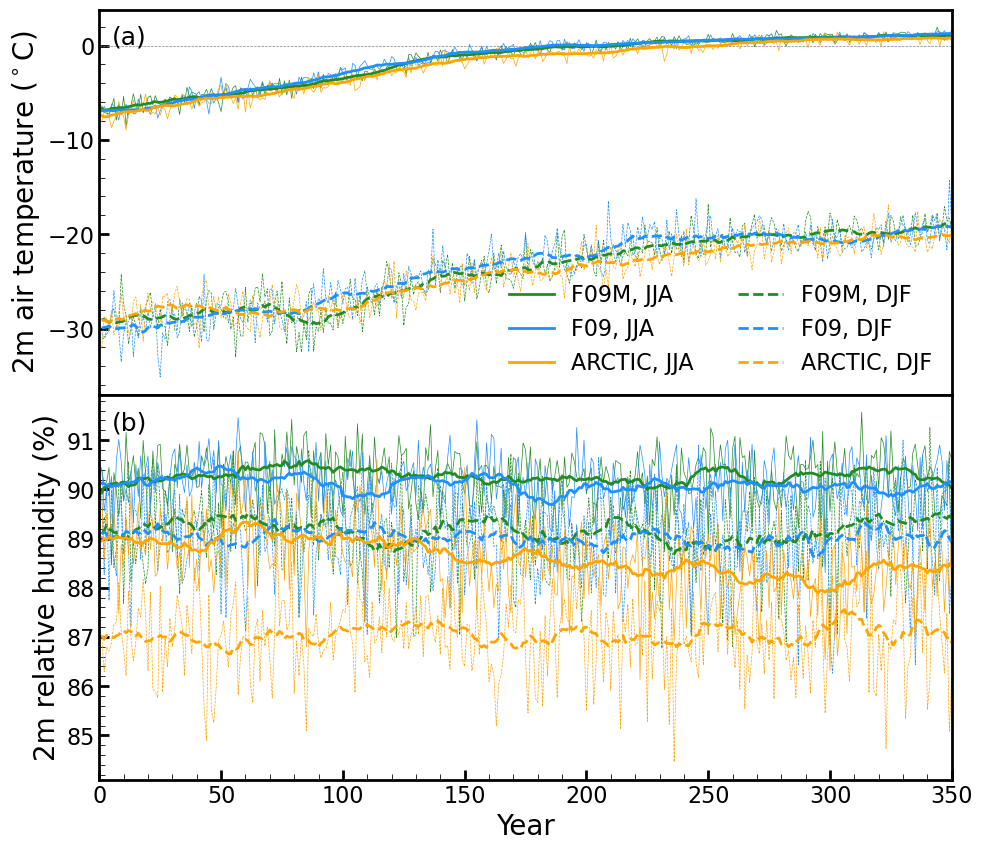

In [25]:
# 2m air temperature, relative humidity
fig = plt.figure(figsize = (11,10))
gs=GridSpec(10,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 16
size_text = 18

year = np.arange(1,351)

#-------------------------------------------- T2m --------------------------------------------
ax1 = plt.subplot(gs[0:5,0:11])

plt.axhline(y=0., color='gray', linestyle='--', linewidth=0.5)
ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_JJA, color='forestgreen', linewidth = 0.5)
ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_DJF, color='forestgreen', linestyle='--', linewidth = 0.5)
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_JJA, color='dodgerblue', linewidth=0.5)
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_DJF, color='dodgerblue', linestyle='--', linewidth=0.5)
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_JJA, color='orange', linewidth=0.5)
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_DJF, color='orange', linestyle='--', linewidth=0.5)

ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_JJA_rm, color='forestgreen', linewidth = 2, label='F09M, JJA')
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_JJA_rm, color='dodgerblue', linewidth = 2, label='F09, JJA')
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_JJA_rm, color='orange', linewidth=2, label='ARCTIC, JJA')
ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_DJF_rm, color='forestgreen', linestyle='--', linewidth = 2, label='F09M, DJF')
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_DJF_rm, color='dodgerblue', linestyle='--', linewidth = 2, label='F09, DJF')
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_DJF_rm, color='orange', linestyle='--', linewidth=2, label='ARCTIC, DJF')

ax1.legend(loc = 'lower right', frameon = False, prop={'size':size_legend}, ncol=2)

ax1.set_xlim([0, 350])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('2m air temperature ($\mathregular{^\circ}$C)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
ax1.axes.get_xaxis().set_visible(False)
plt.text(5, 0.2, '(a)', fontsize=size_text)

#-------------------------------------------- RH2m --------------------------------------------
ax2 = plt.subplot(gs[5:10,0:11])

ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_JJA, color='forestgreen', linewidth = 0.5)
ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_DJF, color='forestgreen', linestyle='--', linewidth = 0.5)
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_JJA, color='dodgerblue', linewidth = 0.5)
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_DJF, color='dodgerblue', linestyle='--', linewidth = 0.5)
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_JJA, color='orange', linewidth = 0.5)
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_DJF, color='orange', linestyle='--', linewidth = 0.5)

ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_JJA_rm, color='forestgreen', linewidth = 2, label='F09M, JJA')
ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_DJF_rm, color='forestgreen', linestyle='--', linewidth = 2, label='F09M, DJF')
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_JJA_rm, color='dodgerblue', linewidth = 2, label='F09, JJA')
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_DJF_rm, color='dodgerblue', linestyle='--', linewidth = 2, label='F09, DJF')
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_JJA_rm, color='orange', linewidth = 2, label='ARCTIC, JJA')
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_DJF_rm, color='orange', linestyle='--', linewidth = 2, label='ARCTIC, DJF')

ax2.set_xlim([0, 350])
ax2.set_xlabel('Year', fontsize=size_label)
ax2.set_ylabel('2m relative humidity (%)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
ax2.tick_params(labelsize=size_tick)
plt.text(5, 91.2, '(b)', fontsize=size_text)


plt.subplots_adjust(hspace=0)
plt.savefig(home_dir+'dynamic_GrIS/github/plot/tseries_avg_T2m_RH2m.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

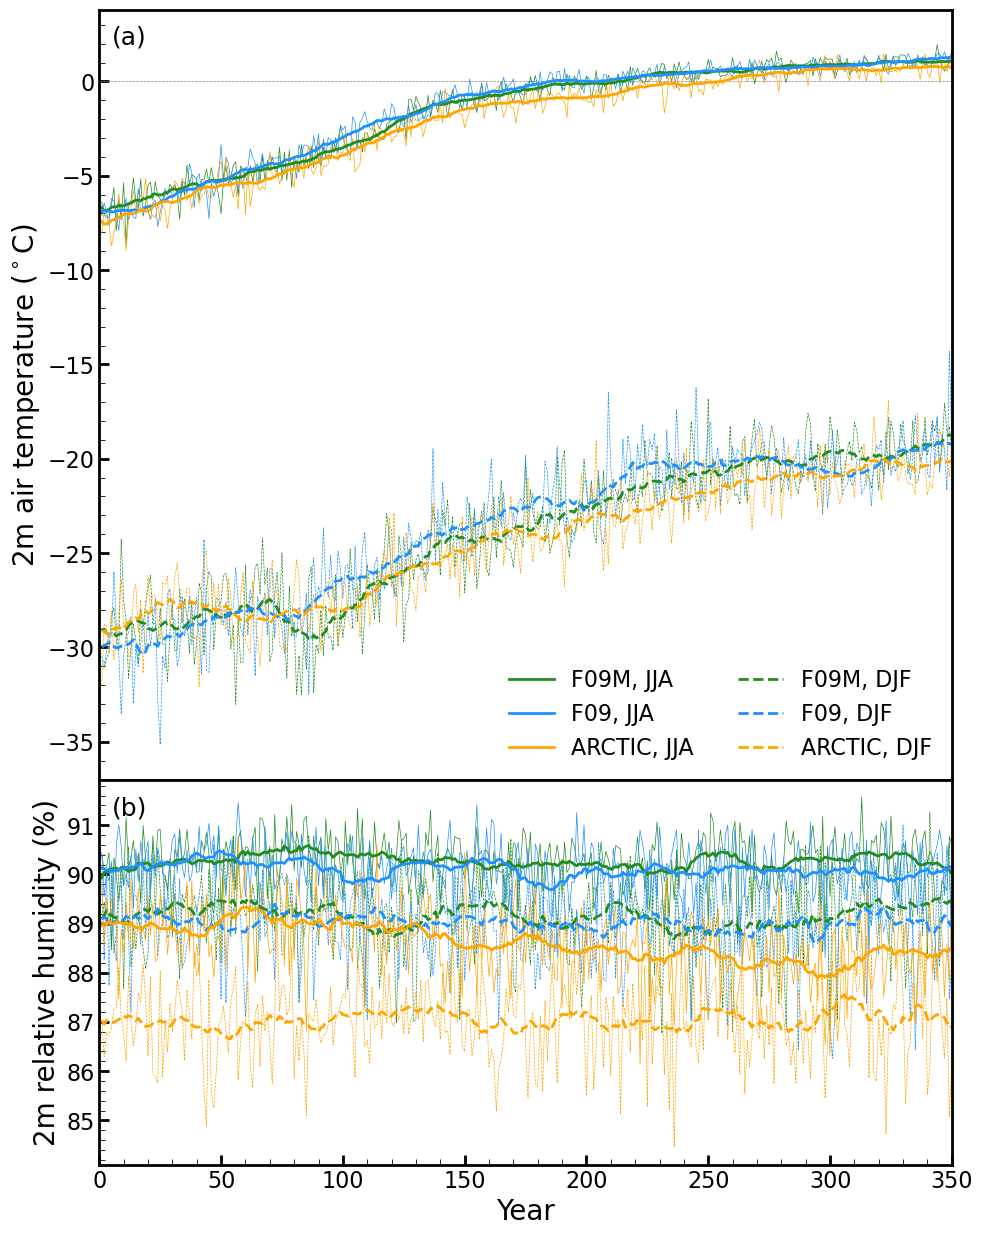

In [24]:
# 2m air temperature, relative humidity
fig = plt.figure(figsize = (11,15))
gs=GridSpec(15,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 16
size_text = 18

year = np.arange(1,351)

#-------------------------------------------- T2m --------------------------------------------
ax1 = plt.subplot(gs[0:10,0:11])

plt.axhline(y=0., color='gray', linestyle='--', linewidth=0.5)
ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_JJA, color='forestgreen', linewidth = 0.5)
ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_DJF, color='forestgreen', linestyle='--', linewidth = 0.5)
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_JJA, color='dodgerblue', linewidth=0.5)
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_DJF, color='dodgerblue', linestyle='--', linewidth=0.5)
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_JJA, color='orange', linewidth=0.5)
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_DJF, color='orange', linestyle='--', linewidth=0.5)

ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_JJA_rm, color='forestgreen', linewidth = 2, label='F09M, JJA')
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_JJA_rm, color='dodgerblue', linewidth = 2, label='F09, JJA')
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_JJA_rm, color='orange', linewidth=2, label='ARCTIC, JJA')
ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_DJF_rm, color='forestgreen', linestyle='--', linewidth = 2, label='F09M, DJF')
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_DJF_rm, color='dodgerblue', linestyle='--', linewidth = 2, label='F09, DJF')
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_DJF_rm, color='orange', linestyle='--', linewidth=2, label='ARCTIC, DJF')

ax1.legend(loc = 'lower right', frameon = False, prop={'size':size_legend}, ncol=2)

ax1.set_xlim([0, 350])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('2m air temperature ($\mathregular{^\circ}$C)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
ax1.axes.get_xaxis().set_visible(False)
plt.text(5, 2, '(a)', fontsize=size_text)

#-------------------------------------------- RH2m --------------------------------------------
ax2 = plt.subplot(gs[10:15,0:11])

ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_JJA, color='forestgreen', linewidth = 0.5)
ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_DJF, color='forestgreen', linestyle='--', linewidth = 0.5)
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_JJA, color='dodgerblue', linewidth = 0.5)
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_DJF, color='dodgerblue', linestyle='--', linewidth = 0.5)
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_JJA, color='orange', linewidth = 0.5)
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_DJF, color='orange', linestyle='--', linewidth = 0.5)

ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_JJA_rm, color='forestgreen', linewidth = 2, label='F09M, JJA')
ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_DJF_rm, color='forestgreen', linestyle='--', linewidth = 2, label='F09M, DJF')
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_JJA_rm, color='dodgerblue', linewidth = 2, label='F09, JJA')
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_DJF_rm, color='dodgerblue', linestyle='--', linewidth = 2, label='F09, DJF')
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_JJA_rm, color='orange', linewidth = 2, label='ARCTIC, JJA')
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_DJF_rm, color='orange', linestyle='--', linewidth = 2, label='ARCTIC, DJF')

ax2.set_xlim([0, 350])
ax2.set_xlabel('Year', fontsize=size_label)
ax2.set_ylabel('2m relative humidity (%)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
ax2.tick_params(labelsize=size_tick)
plt.text(5, 91.2, '(b)', fontsize=size_text)


plt.subplots_adjust(hspace=0)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_avg_T2m_RH2m_v2.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

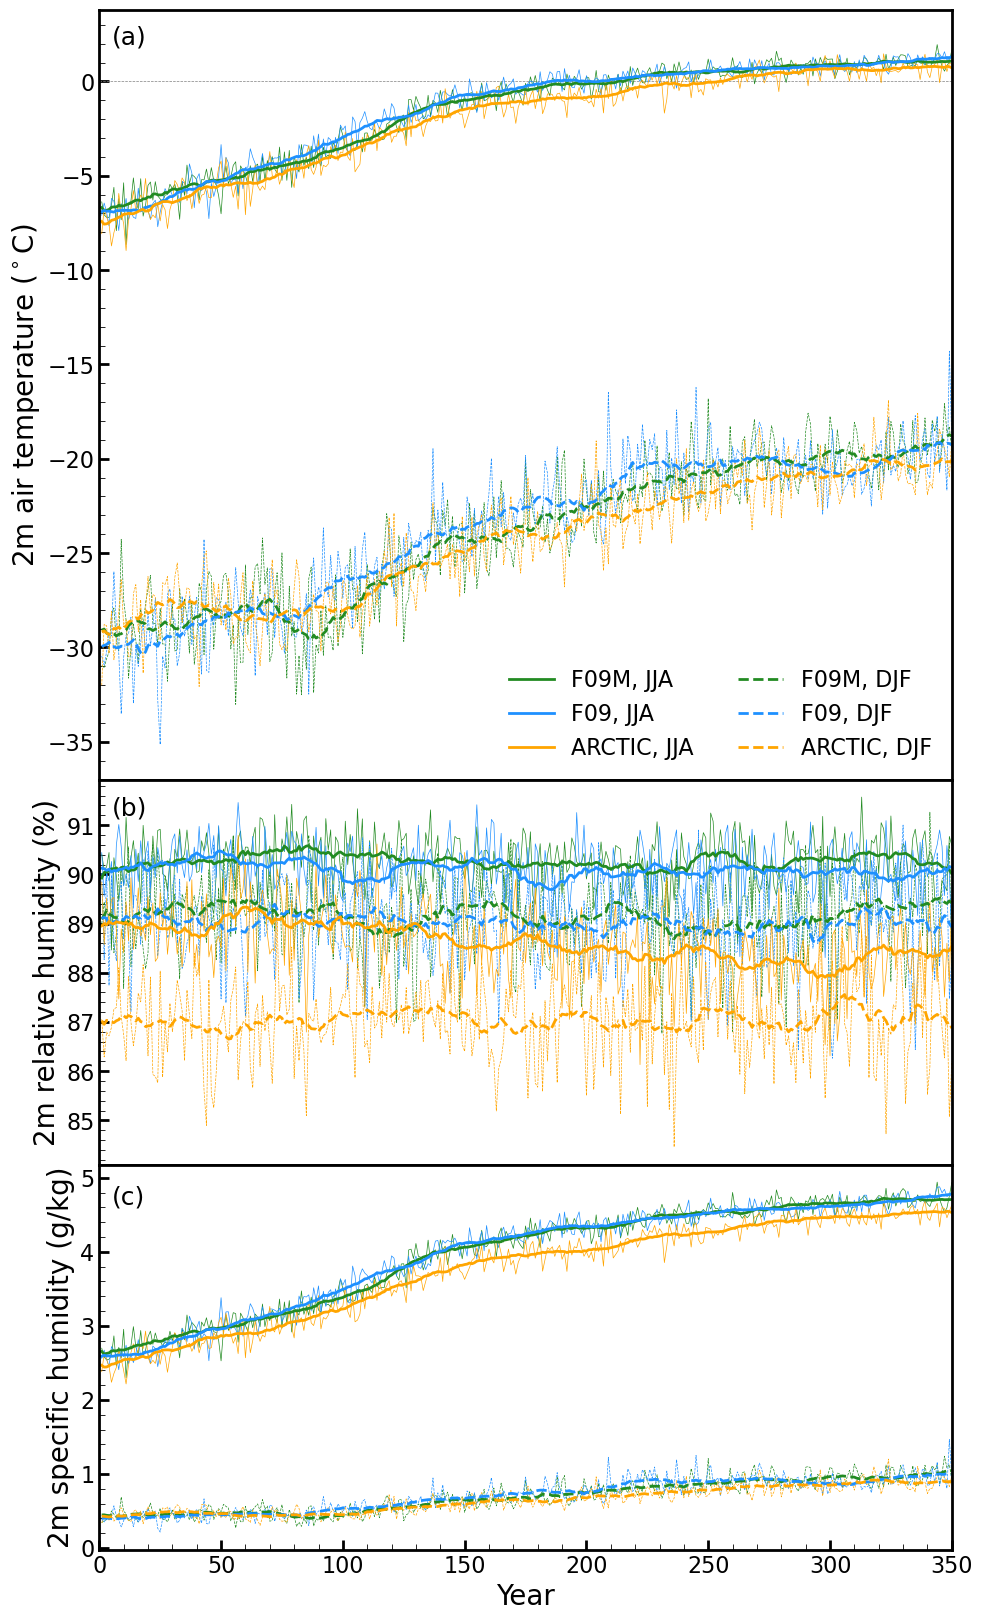

In [16]:
# 2m air temperature, relative humidity, specific humidity
fig = plt.figure(figsize = (11,20))
gs=GridSpec(20,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 16
size_text = 18

year = np.arange(1,351)

#-------------------------------------------- T2m --------------------------------------------
ax1 = plt.subplot(gs[0:10,0:11])

plt.axhline(y=0., color='gray', linestyle='--', linewidth=0.5)
ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_JJA, color='forestgreen', linewidth = 0.5)
ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_DJF, color='forestgreen', linestyle='--', linewidth = 0.5)
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_JJA, color='dodgerblue', linewidth=0.5)
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_DJF, color='dodgerblue', linestyle='--', linewidth=0.5)
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_JJA, color='orange', linewidth=0.5)
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_DJF, color='orange', linestyle='--', linewidth=0.5)

ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_JJA_rm, color='forestgreen', linewidth = 2, label='F09M, JJA')
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_JJA_rm, color='dodgerblue', linewidth = 2, label='F09, JJA')
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_JJA_rm, color='orange', linewidth=2, label='ARCTIC, JJA')
ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_DJF_rm, color='forestgreen', linestyle='--', linewidth = 2, label='F09M, DJF')
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_DJF_rm, color='dodgerblue', linestyle='--', linewidth = 2, label='F09, DJF')
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_DJF_rm, color='orange', linestyle='--', linewidth=2, label='ARCTIC, DJF')

ax1.legend(loc = 'lower right', frameon = False, prop={'size':size_legend}, ncol=2)

ax1.set_xlim([0, 350])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('2m air temperature ($\mathregular{^\circ}$C)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
ax1.axes.get_xaxis().set_visible(False)
plt.text(5, 2, '(a)', fontsize=size_text)

#-------------------------------------------- RH2m --------------------------------------------
ax2 = plt.subplot(gs[10:15,0:11])

ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_JJA, color='forestgreen', linewidth = 0.5)
ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_DJF, color='forestgreen', linestyle='--', linewidth = 0.5)
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_JJA, color='dodgerblue', linewidth = 0.5)
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_DJF, color='dodgerblue', linestyle='--', linewidth = 0.5)
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_JJA, color='orange', linewidth = 0.5)
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_DJF, color='orange', linestyle='--', linewidth = 0.5)

ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_JJA_rm, color='forestgreen', linewidth = 2, label='F09M, JJA')
ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_DJF_rm, color='forestgreen', linestyle='--', linewidth = 2, label='F09M, DJF')
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_JJA_rm, color='dodgerblue', linewidth = 2, label='F09, JJA')
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_DJF_rm, color='dodgerblue', linestyle='--', linewidth = 2, label='F09, DJF')
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_JJA_rm, color='orange', linewidth = 2, label='ARCTIC, JJA')
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_DJF_rm, color='orange', linestyle='--', linewidth = 2, label='ARCTIC, DJF')

ax2.set_xlim([0, 350])
ax2.set_xlabel('Year', fontsize=size_label)
ax2.set_ylabel('2m relative humidity (%)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
ax2.tick_params(labelsize=size_tick)
ax2.axes.get_xaxis().set_visible(False)
plt.text(5, 91.2, '(b)', fontsize=size_text)

#-------------------------------------------- Q2m --------------------------------------------
ax3 = plt.subplot(gs[15:20,0:11])

ax3.plot(year, F09M_avg_1pctCO2_4xext_Q2M_JJA*1e3, color='forestgreen', linewidth = 0.5)
ax3.plot(year, F09M_avg_1pctCO2_4xext_Q2M_DJF*1e3, color='forestgreen', linestyle='--', linewidth = 0.5)
ax3.plot(year, F09_avg_1pctCO2_4xext_Q2M_JJA*1e3, color='dodgerblue', linewidth = 0.5)
ax3.plot(year, F09_avg_1pctCO2_4xext_Q2M_DJF*1e3, color='dodgerblue', linestyle='--', linewidth = 0.5)
ax3.plot(year, ARCTIC_avg_1pctCO2_4xext_Q2M_JJA*1e3, color='orange', linewidth = 0.5)
ax3.plot(year, ARCTIC_avg_1pctCO2_4xext_Q2M_DJF*1e3, color='orange', linestyle='--', linewidth = 0.5)

ax3.plot(year, F09M_avg_1pctCO2_4xext_Q2M_JJA_rm*1e3, color='forestgreen', linewidth = 2, label='F09M, JJA')
ax3.plot(year, F09M_avg_1pctCO2_4xext_Q2M_DJF_rm*1e3, color='forestgreen', linestyle='--', linewidth = 2, label='F09M, DJF')
ax3.plot(year, F09_avg_1pctCO2_4xext_Q2M_JJA_rm*1e3, color='dodgerblue', linewidth = 2, label='F09, JJA')
ax3.plot(year, F09_avg_1pctCO2_4xext_Q2M_DJF_rm*1e3, color='dodgerblue', linestyle='--', linewidth = 2, label='F09, DJF')
ax3.plot(year, ARCTIC_avg_1pctCO2_4xext_Q2M_JJA_rm*1e3, color='orange', linewidth = 2, label='ARCTIC, JJA')
ax3.plot(year, ARCTIC_avg_1pctCO2_4xext_Q2M_DJF_rm*1e3, color='orange', linestyle='--', linewidth = 2, label='ARCTIC, DJF')
#ax3.plot(year, F09M_avg_1pctCO2_4xext_QBOT_JJA_rm*1e3, color='forestgreen', linewidth = 1, label='F09M, JJA')
#ax3.plot(year, F09M_avg_1pctCO2_4xext_QBOT_DJF_rm*1e3, color='forestgreen', linestyle='--', linewidth = 2, label='F09M, DJF')
#ax3.plot(year, F09_avg_1pctCO2_4xext_QBOT_JJA_rm*1e3, color='dodgerblue', linewidth = 1, label='F09, JJA')
#ax3.plot(year, F09_avg_1pctCO2_4xext_QBOT_DJF_rm*1e3, color='dodgerblue', linestyle='--', linewidth = 2, label='F09, DJF')
#ax3.plot(year, ARCTIC_avg_1pctCO2_4xext_QBOT_JJA_rm*1e3, color='orange', linewidth = 1, label='ARCTIC, JJA')
#ax3.plot(year, ARCTIC_avg_1pctCO2_4xext_QBOT_DJF_rm*1e3, color='orange', linestyle='--', linewidth = 2, label='ARCTIC, DJF')
ax3.set_xlim([0, 350])
ax3.set_xlabel('Year', fontsize=size_label)
ax3.set_ylabel('2m specific humidity (g/kg)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in')
ax3.tick_params(which='minor', length=4, direction='in')
ax3.tick_params(labelsize=size_tick)
plt.text(5, 4.65, '(c)', fontsize=size_text)


plt.subplots_adjust(hspace=0)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_avg_T2m_RH2m_Q2m.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

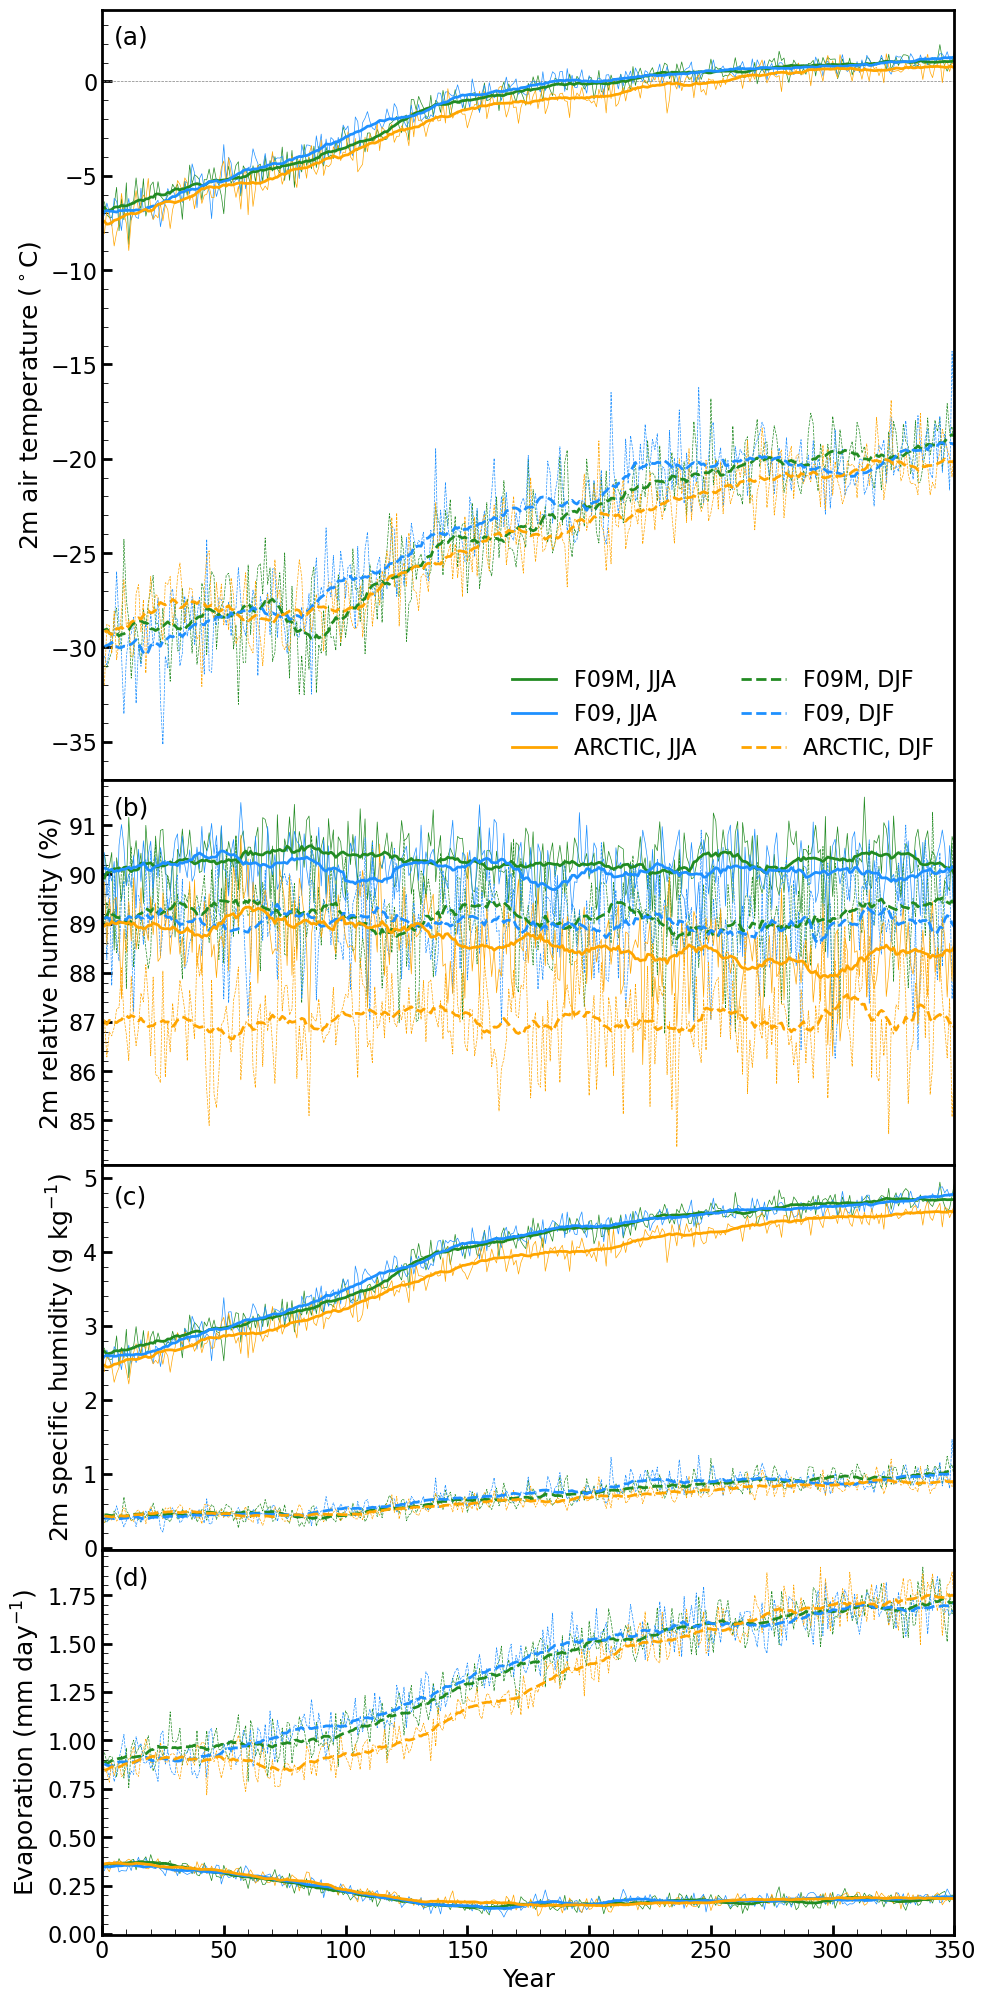

In [41]:
# 2m air temperature, relative humidity, specific humidity, evaporation (over the Arctic Ocean)
fig = plt.figure(figsize = (11,25))
gs=GridSpec(25,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 18
size_legend = 16
size_text = 18

year = np.arange(1,351)

#-------------------------------------------- T2m --------------------------------------------
ax1 = plt.subplot(gs[0:10,0:11])

plt.axhline(y=0., color='gray', linestyle='--', linewidth=0.5)
ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_JJA, color='forestgreen', linewidth = 0.5)
ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_DJF, color='forestgreen', linestyle='--', linewidth = 0.5)
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_JJA, color='dodgerblue', linewidth=0.5)
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_DJF, color='dodgerblue', linestyle='--', linewidth=0.5)
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_JJA, color='orange', linewidth=0.5)
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_DJF, color='orange', linestyle='--', linewidth=0.5)

ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_JJA_rm, color='forestgreen', linewidth = 2, label='F09M, JJA')
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_JJA_rm, color='dodgerblue', linewidth = 2, label='F09, JJA')
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_JJA_rm, color='orange', linewidth=2, label='ARCTIC, JJA')
ax1.plot(year, F09M_avg_1pctCO2_4xext_TREFHT_DJF_rm, color='forestgreen', linestyle='--', linewidth = 2, label='F09M, DJF')
ax1.plot(year, F09_avg_1pctCO2_4xext_TREFHT_DJF_rm, color='dodgerblue', linestyle='--', linewidth = 2, label='F09, DJF')
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_TREFHT_DJF_rm, color='orange', linestyle='--', linewidth=2, label='ARCTIC, DJF')

ax1.legend(loc = 'lower right', frameon = False, prop={'size':size_legend}, ncol=2)

ax1.set_xlim([0, 350])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('2m air temperature ($\mathregular{^\circ}$C)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
ax1.axes.get_xaxis().set_visible(False)
plt.text(5, 2, '(a)', fontsize=size_text)

#-------------------------------------------- RH2m --------------------------------------------
ax2 = plt.subplot(gs[10:15,0:11])

ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_JJA, color='forestgreen', linewidth = 0.5)
ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_DJF, color='forestgreen', linestyle='--', linewidth = 0.5)
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_JJA, color='dodgerblue', linewidth = 0.5)
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_DJF, color='dodgerblue', linestyle='--', linewidth = 0.5)
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_JJA, color='orange', linewidth = 0.5)
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_DJF, color='orange', linestyle='--', linewidth = 0.5)

ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_JJA_rm, color='forestgreen', linewidth = 2, label='F09M, JJA')
ax2.plot(year, F09M_avg_1pctCO2_4xext_RH2M_DJF_rm, color='forestgreen', linestyle='--', linewidth = 2, label='F09M, DJF')
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_JJA_rm, color='dodgerblue', linewidth = 2, label='F09, JJA')
ax2.plot(year, F09_avg_1pctCO2_4xext_RH2M_DJF_rm, color='dodgerblue', linestyle='--', linewidth = 2, label='F09, DJF')
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_JJA_rm, color='orange', linewidth = 2, label='ARCTIC, JJA')
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_RH2M_DJF_rm, color='orange', linestyle='--', linewidth = 2, label='ARCTIC, DJF')

ax2.set_xlim([0, 350])
ax2.set_xlabel('Year', fontsize=size_label)
ax2.set_ylabel('2m relative humidity (%)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
ax2.tick_params(labelsize=size_tick)
ax2.axes.get_xaxis().set_visible(False)
plt.text(5, 91.2, '(b)', fontsize=size_text)

#-------------------------------------------- Q2m --------------------------------------------
ax3 = plt.subplot(gs[15:20,0:11])

ax3.plot(year, F09M_avg_1pctCO2_4xext_Q2M_JJA*1e3, color='forestgreen', linewidth = 0.5)
ax3.plot(year, F09M_avg_1pctCO2_4xext_Q2M_DJF*1e3, color='forestgreen', linestyle='--', linewidth = 0.5)
ax3.plot(year, F09_avg_1pctCO2_4xext_Q2M_JJA*1e3, color='dodgerblue', linewidth = 0.5)
ax3.plot(year, F09_avg_1pctCO2_4xext_Q2M_DJF*1e3, color='dodgerblue', linestyle='--', linewidth = 0.5)
ax3.plot(year, ARCTIC_avg_1pctCO2_4xext_Q2M_JJA*1e3, color='orange', linewidth = 0.5)
ax3.plot(year, ARCTIC_avg_1pctCO2_4xext_Q2M_DJF*1e3, color='orange', linestyle='--', linewidth = 0.5)

ax3.plot(year, F09M_avg_1pctCO2_4xext_Q2M_JJA_rm*1e3, color='forestgreen', linewidth = 2, label='F09M, JJA')
ax3.plot(year, F09M_avg_1pctCO2_4xext_Q2M_DJF_rm*1e3, color='forestgreen', linestyle='--', linewidth = 2, label='F09M, DJF')
ax3.plot(year, F09_avg_1pctCO2_4xext_Q2M_JJA_rm*1e3, color='dodgerblue', linewidth = 2, label='F09, JJA')
ax3.plot(year, F09_avg_1pctCO2_4xext_Q2M_DJF_rm*1e3, color='dodgerblue', linestyle='--', linewidth = 2, label='F09, DJF')
ax3.plot(year, ARCTIC_avg_1pctCO2_4xext_Q2M_JJA_rm*1e3, color='orange', linewidth = 2, label='ARCTIC, JJA')
ax3.plot(year, ARCTIC_avg_1pctCO2_4xext_Q2M_DJF_rm*1e3, color='orange', linestyle='--', linewidth = 2, label='ARCTIC, DJF')
#ax3.plot(year, F09M_avg_1pctCO2_4xext_QBOT_JJA_rm*1e3, color='forestgreen', linewidth = 1, label='F09M, JJA')
#ax3.plot(year, F09M_avg_1pctCO2_4xext_QBOT_DJF_rm*1e3, color='forestgreen', linestyle='--', linewidth = 2, label='F09M, DJF')
#ax3.plot(year, F09_avg_1pctCO2_4xext_QBOT_JJA_rm*1e3, color='dodgerblue', linewidth = 1, label='F09, JJA')
#ax3.plot(year, F09_avg_1pctCO2_4xext_QBOT_DJF_rm*1e3, color='dodgerblue', linestyle='--', linewidth = 2, label='F09, DJF')
#ax3.plot(year, ARCTIC_avg_1pctCO2_4xext_QBOT_JJA_rm*1e3, color='orange', linewidth = 1, label='ARCTIC, JJA')
#ax3.plot(year, ARCTIC_avg_1pctCO2_4xext_QBOT_DJF_rm*1e3, color='orange', linestyle='--', linewidth = 2, label='ARCTIC, DJF')

ax3.set_xlim([0, 350])
ax3.set_xlabel('Year', fontsize=size_label)
ax3.set_ylabel('2m specific humidity (g kg$\mathregular{^{-1}}$)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in')
ax3.tick_params(which='minor', length=4, direction='in')
ax3.tick_params(labelsize=size_tick)
ax3.axes.get_xaxis().set_visible(False)
plt.text(5, 4.65, '(c)', fontsize=size_text)

#-------------------------------------------- QFLX --------------------------------------------
ax4 = plt.subplot(gs[20:25,0:11])

ax4.plot(year, F09M_avg_1pctCO2_4xext_QFLX_JJA, color='forestgreen', linewidth = 0.5)
ax4.plot(year, F09M_avg_1pctCO2_4xext_QFLX_DJF, color='forestgreen', linestyle='--', linewidth = 0.5)
ax4.plot(year, F09_avg_1pctCO2_4xext_QFLX_JJA, color='dodgerblue', linewidth = 0.5)
ax4.plot(year, F09_avg_1pctCO2_4xext_QFLX_DJF, color='dodgerblue', linestyle='--', linewidth = 0.5)
ax4.plot(year, ARCTIC_avg_1pctCO2_4xext_QFLX_JJA, color='orange', linewidth = 0.5)
ax4.plot(year, ARCTIC_avg_1pctCO2_4xext_QFLX_DJF, color='orange', linestyle='--', linewidth = 0.5)

ax4.plot(year, F09M_avg_1pctCO2_4xext_QFLX_JJA_rm, color='forestgreen', linewidth = 2, label='F09M, JJA')
ax4.plot(year, F09M_avg_1pctCO2_4xext_QFLX_DJF_rm, color='forestgreen', linestyle='--', linewidth = 2, label='F09M, DJF')
ax4.plot(year, F09_avg_1pctCO2_4xext_QFLX_JJA_rm, color='dodgerblue', linewidth = 2, label='F09, JJA')
ax4.plot(year, F09_avg_1pctCO2_4xext_QFLX_DJF_rm, color='dodgerblue', linestyle='--', linewidth = 2, label='F09, DJF')
ax4.plot(year, ARCTIC_avg_1pctCO2_4xext_QFLX_JJA_rm, color='orange', linewidth = 2, label='ARCTIC, JJA')
ax4.plot(year, ARCTIC_avg_1pctCO2_4xext_QFLX_DJF_rm, color='orange', linestyle='--', linewidth = 2, label='ARCTIC, DJF')

ax4.set_xlim([0, 350])
ax4.set_xlabel('Year', fontsize=size_label)
ax4.set_ylabel('Evaporation (mm day$\mathregular{^{-1}}$)', fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which='major', length=7, width=2, direction='in')
ax4.tick_params(which='minor', length=4, direction='in')
ax4.tick_params(labelsize=size_tick)
plt.text(5, 1.8, '(d)', fontsize=size_text)


plt.subplots_adjust(hspace=0)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_avg_T2m_RH2m_Q2m_QFLX.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

## 2. Maps of annual mean sea ice concentration and JJA mean evaporation <a class="anchor" id="second-bullet"></a>

### Read data

In [44]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_aice_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_aice_1pctCO2_yearly.nc')['aice'][:140]
f09_1pctCO2_aice_Mar = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_aice_1pctCO2_Mar.nc')['aice'][:140]
lon = f09_1pctCO2_aice_yearly.TLON
lat = f09_1pctCO2_aice_yearly.TLAT
f09_1pctCO2_QFLX_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QFLX_1pctCO2_JJA_yearly.nc')['QFLX'][:140] #[kg/m2/s]
f09_lat = f09_1pctCO2_QFLX_JJA.lat
f09_lon = f09_1pctCO2_QFLX_JJA.lon

# 4xCO2
f09_4xext_aice_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_aice_4xext_yearly.nc')['aice']
f09_4xext_aice_Mar = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_aice_4xext_Mar.nc')['aice']
f09_4xext_QFLX_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QFLX_4xext_JJA_yearly.nc')['QFLX']

# Combine
f09_1pctCO2_4xext_aice_yearly = xr.concat([f09_1pctCO2_aice_yearly, f09_4xext_aice_yearly], dim='time')
f09_1pctCO2_4xext_aice_Mar = xr.concat([f09_1pctCO2_aice_Mar, f09_4xext_aice_Mar], dim='time')
f09_1pctCO2_4xext_QFLX_JJA = xr.concat([f09_1pctCO2_QFLX_JJA, f09_4xext_QFLX_JJA], dim='time')

In [41]:
## f09nohacks
# 1pctCO2
f09_nohacks_1pctCO2_aice_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_aice_1pctCO2_yearly.nc')['aice']
f09_nohacks_1pctCO2_aice_Mar = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_aice_1pctCO2_Mar.nc')['aice']
f09_nohacks_1pctCO2_QFLX_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QFLX_1pctCO2_JJA_yearly.nc')['QFLX']

# 4xext
f09_nohacks_4xext_aice_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_aice_4xext_yearly.nc')['aice']
f09_nohacks_4xext_aice_Mar = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_aice_4xext_Mar.nc')['aice']
f09_nohacks_4xext_QFLX_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QFLX_4xext_JJA_yearly.nc')['QFLX']

# Combine
f09_nohacks_1pctCO2_4xext_aice_yearly = xr.concat([f09_nohacks_1pctCO2_aice_yearly, f09_nohacks_4xext_aice_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_aice_Mar = xr.concat([f09_nohacks_1pctCO2_aice_Mar, f09_nohacks_4xext_aice_Mar], dim='time')
f09_nohacks_1pctCO2_4xext_QFLX_JJA = xr.concat([f09_nohacks_1pctCO2_QFLX_JJA, f09_nohacks_4xext_QFLX_JJA], dim='time')

In [4]:
## ARCTIC
# 1pctCO2
ARCTIC_1pctCO2_aice_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_aice_1pctCO2_yearly.nc')['aice']
ARCTIC_1pctCO2_aice_Mar = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_aice_1pctCO2_Mar.nc')['aice']
ARCTIC_1pctCO2_QFLX_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QFLX_1pctCO2_JJA_yearly.nc')['QFLX']
ARCTIC_lon = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_lon.nc')['lon'].values
ARCTIC_lat = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_lat.nc')['lat'].values

# 4xext
ARCTIC_4xext_aice_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_aice_4xext_yearly.nc')['aice']
ARCTIC_4xext_aice_Mar = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_aice_4xext_Mar.nc')['aice']
ARCTIC_4xext_QFLX_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QFLX_4xext_JJA_yearly.nc')['QFLX']

# Combine
ARCTIC_1pctCO2_4xext_aice_yearly = xr.concat([ARCTIC_1pctCO2_aice_yearly, ARCTIC_4xext_aice_yearly], dim='time')
ARCTIC_1pctCO2_4xext_aice_Mar = xr.concat([ARCTIC_1pctCO2_aice_Mar, ARCTIC_4xext_aice_Mar], dim='time')
ARCTIC_1pctCO2_4xext_QFLX_JJA = xr.concat([ARCTIC_1pctCO2_QFLX_JJA, ARCTIC_4xext_QFLX_JJA], dim='time')

In [5]:
tarea = xr.open_dataset('/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001/ice/hist/cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001.cice.h.0001-01.nc')['tarea']
TLAT = xr.open_dataset('/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001/ice/hist/cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001.cice.h.0001-01.nc')['TLAT']

### Select

In [65]:
# Year 151-250 (large divergence period)
f09_aice_div = f09_1pctCO2_4xext_aice_yearly[150:250,:,:].mean(dim='time')
f09_QFLX_JJA_div = f09_1pctCO2_4xext_QFLX_JJA[150:250,:,:].mean(dim='time') * (24*3600) # [mm/day]

f09_nohacks_aice_div = f09_nohacks_1pctCO2_4xext_aice_yearly[150:250,:,:].mean(dim='time')
f09_nohacks_QFLX_JJA_div = f09_nohacks_1pctCO2_4xext_QFLX_JJA[150:250,:,:].mean(dim='time') * (24*3600)

ARCTIC_aice_div = ARCTIC_1pctCO2_4xext_aice_yearly[150:250,:].mean(dim='time')
ARCTIC_QFLX_JJA_div = ARCTIC_1pctCO2_4xext_QFLX_JJA[150:250,:].mean(dim='time') * (24*3600)

### Calculate

In [83]:
## Calculate difference
ARCTIC_f09_aice_diff_div = ARCTIC_aice_div.where(ARCTIC_aice_div!=0.) - f09_aice_div.where(f09_aice_div!=0.)
ARCTIC_f09_QFLX_JJA_diff_div = xr.DataArray(ARCTIC_QFLX_JJA_div.values - f09_QFLX_JJA_div.values)

ARCTIC_f09_nohacks_aice_diff_div = ARCTIC_aice_div.where(ARCTIC_aice_div!=0.) - f09_nohacks_aice_div.where(f09_nohacks_aice_div!=0.)
ARCTIC_f09_nohacks_QFLX_JJA_diff_div = xr.DataArray(ARCTIC_QFLX_JJA_div.values - f09_nohacks_QFLX_JJA_div.values)

In [19]:
## Add cyclic points
f09_ARCTIC_FSDS_diff_stab2, f09_lon2 = add_cyclic_point(f09_ARCTIC_FSDS_diff_stab, coord=f09_lon)
f09_nohacks_ARCTIC_FSDS_diff_stab2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_FSDS_diff_stab, coord=f09_lon)

### Plot

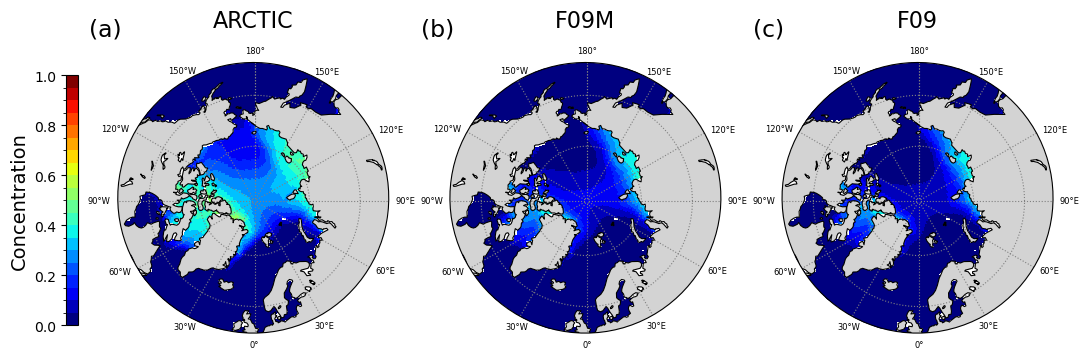

In [39]:
# Sea ice concentration
fig = plt.figure(figsize = (12,5))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad']=14

# Modify values here
size_title = 16

cmap1 = plt.cm.jet
bounds1 = np.arange(0.,1.01,0.05)
bounds1min = [-5]
bounds1max = [5]
norm1 = colors.BoundaryNorm(bounds1, cmap1.N)#, extend='max')
ticks1 = np.arange(0.,1.01,0.2)

cmap2 = plt.cm.RdBu
bounds2 = np.arange(-0.3,0.31,0.05)
bounds2min = [-5]
bounds2max = [5]
norm2 = colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-0.3,0.31,0.1)

#=============line1===============
ax1 = plt.subplot(gs[0],projection=crs_ortho)
plot_arctic(ax1,50)
im1 = ax1.pcolormesh(lon, lat, ARCTIC_aice_div, transform=crs_ll, cmap=cmap1, norm=norm1)
ax1.set_title('ARCTIC', fontsize=size_title)#, weight='bold')
ax1.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax1.add_feature(cfeature.COASTLINE, zorder=3, lw=0.8)
ax1.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='white')
gl = ax1.gridlines(color='gray', lw=0.8, ls=':', crs=ccrs.PlateCarree(), draw_labels=True, rotate_labels=False)
gl.xlocator = mpl.ticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mpl.ticker.FixedLocator([-90, -75, -60, -30, 0, 30, 45, 60, 75, 90])
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}
plt.text(-5000000, 5000000, '(a)', fontsize=17)#, weight='bold')

# colorbar
cbar_ax1 = fig.add_axes([0.08, 0.24, 0.01, 0.5])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb1.set_label(label='Concentration', size=14)
cb1.ax.tick_params(labelsize=10)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

ax2 = plt.subplot(gs[1],projection=crs_ortho)
plot_arctic(ax2,50)
im2 = ax2.pcolormesh(lon, lat, f09_aice_div, transform=crs_ll, cmap=cmap1, norm=norm1)
#ax2.contourf(lon, lat, case21_22_sig_mam_change, transform=crs_ll, hatches=['..'], alpha=0)
ax2.set_title('F09M', fontsize=size_title)#, weight='bold')
ax2.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax2.add_feature(cfeature.COASTLINE, zorder=3, lw=0.8)
ax2.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='white')
gl = ax2.gridlines(color='gray', lw=0.8, ls=':', crs=ccrs.PlateCarree(), draw_labels=True, rotate_labels=False)
gl.xlocator = mpl.ticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mpl.ticker.FixedLocator([-90, -75, -60, -30, 0, 30, 45, 60, 75, 90])
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}
plt.text(-5000000, 5000000, '(b)', fontsize=17)

ax3 = plt.subplot(gs[2],projection=crs_ortho)
plot_arctic(ax3,50)
im3 = ax3.pcolormesh(lon, lat, f09_nohacks_aice_div, transform=crs_ll, cmap=cmap1, norm=norm1)
#ax3.contourf(lon, lat, case31_32_sig_mam_change, transform=crs_ll, hatches=['..'], alpha=0)
ax3.set_title('F09', fontsize=size_title)#, weight='bold')
ax3.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax3.add_feature(cfeature.COASTLINE, zorder=3, lw=0.8)
ax3.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='white')
gl = ax3.gridlines(color='gray', lw=0.8, ls=':', crs=ccrs.PlateCarree(), draw_labels=True, rotate_labels=False)
gl.xlocator = mpl.ticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mpl.ticker.FixedLocator([-90, -75, -60, -30, 0, 30, 45, 60, 75, 90])
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}
plt.text(-5000000, 5000000, '(c)', fontsize=17)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    right=0.9,
                    #top=0.9,
                    wspace=0.25,
                    hspace=0.0)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_aice_div.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

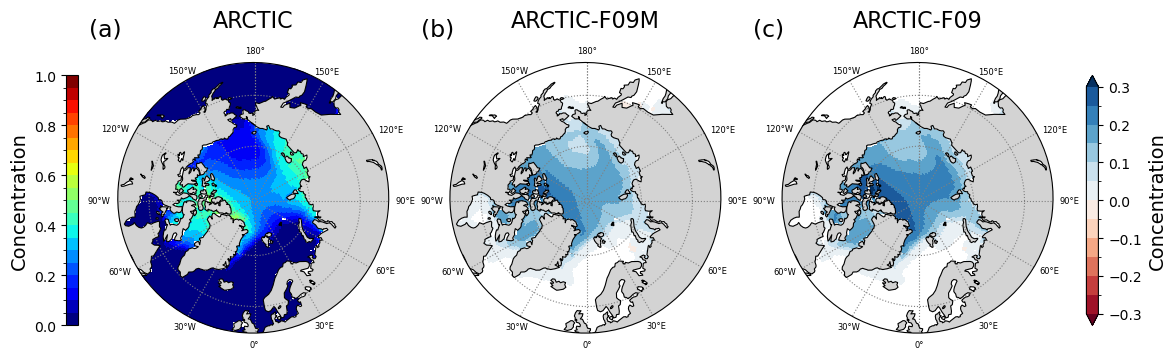

In [38]:
# Sea ice concentration and differences
fig = plt.figure(figsize = (12,5))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad']=14

# Modify values here
size_title = 16

cmap1 = plt.cm.jet
bounds1 = np.arange(0.,1.01,0.05)
bounds1min = [-5]
bounds1max = [5]
norm1 = colors.BoundaryNorm(bounds1, cmap1.N)#, extend='max')
ticks1 = np.arange(0.,1.01,0.2)

cmap2 = plt.cm.RdBu
bounds2 = np.arange(-0.3,0.31,0.05)
bounds2min = [-5]
bounds2max = [5]
norm2 = colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-0.3,0.31,0.1)

#=============line1===============
ax1 = plt.subplot(gs[0],projection=crs_ortho)
plot_arctic(ax1,50)
im1 = ax1.pcolormesh(lon, lat, ARCTIC_aice_div, transform=crs_ll, cmap=cmap1, norm=norm1)
ax1.set_title('ARCTIC', fontsize=size_title)#, weight='bold')
ax1.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax1.add_feature(cfeature.COASTLINE, zorder=3, lw=0.8)
ax1.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='white')
gl = ax1.gridlines(color='gray', lw=0.8, ls=':', crs=ccrs.PlateCarree(), draw_labels=True, rotate_labels=False)
gl.xlocator = mpl.ticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mpl.ticker.FixedLocator([-90, -75, -60, -30, 0, 30, 45, 60, 75, 90])
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}
plt.text(-5000000, 5000000, '(a)', fontsize=17)#, weight='bold')

# colorbar
cbar_ax1 = fig.add_axes([0.08, 0.24, 0.01, 0.5])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb1.set_label(label='Concentration', size=14)
cb1.ax.tick_params(labelsize=10)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

ax2 = plt.subplot(gs[1],projection=crs_ortho)
plot_arctic(ax2,50)
im2 = ax2.pcolormesh(lon, lat, ARCTIC_f09_aice_diff_div, transform=crs_ll, cmap=cmap2, norm=norm2)
#ax2.contourf(lon, lat, case21_22_sig_mam_change, transform=crs_ll, hatches=['..'], alpha=0)
ax2.set_title('ARCTIC-F09M', fontsize=size_title)#, weight='bold')
ax2.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax2.add_feature(cfeature.COASTLINE, zorder=3, lw=0.8)
ax2.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='white')
gl = ax2.gridlines(color='gray', lw=0.8, ls=':', crs=ccrs.PlateCarree(), draw_labels=True, rotate_labels=False)
gl.xlocator = mpl.ticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mpl.ticker.FixedLocator([-90, -75, -60, -30, 0, 30, 45, 60, 75, 90])
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}
plt.text(-5000000, 5000000, '(b)', fontsize=17)

ax3 = plt.subplot(gs[2],projection=crs_ortho)
plot_arctic(ax3,50)
im3 = ax3.pcolormesh(lon, lat, ARCTIC_f09_nohacks_aice_diff_div, transform=crs_ll, cmap=cmap2, norm=norm2)
#ax3.contourf(lon, lat, case31_32_sig_mam_change, transform=crs_ll, hatches=['..'], alpha=0)
ax3.set_title('ARCTIC-F09', fontsize=size_title)#, weight='bold')
ax3.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax3.add_feature(cfeature.COASTLINE, zorder=3, lw=0.8)
ax3.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='white')
gl = ax3.gridlines(color='gray', lw=0.8, ls=':', crs=ccrs.PlateCarree(), draw_labels=True, rotate_labels=False)
gl.xlocator = mpl.ticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mpl.ticker.FixedLocator([-90, -75, -60, -30, 0, 30, 45, 60, 75, 90])
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}
plt.text(-5000000, 5000000, '(c)', fontsize=17)

# colorbar
cbar_ax3 = fig.add_axes([0.93, 0.24, 0.01, 0.5])
cb3 = fig.colorbar(im3, cax=cbar_ax3, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
#cb3 = fig.colorbar(cm.ScalarMappable(norm=norm6, cmap=cmap6), cax=cbar_ax6, orientation='vertical', boundaries=bounds6min+bounds6+bounds6max, ticks=bounds6)
cb3.set_label(label='Concentration', size=14)
cb3.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    right=0.9,
                    #top=0.9,
                    wspace=0.25,
                    hspace=0.0)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_aice_aice_diff_div.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

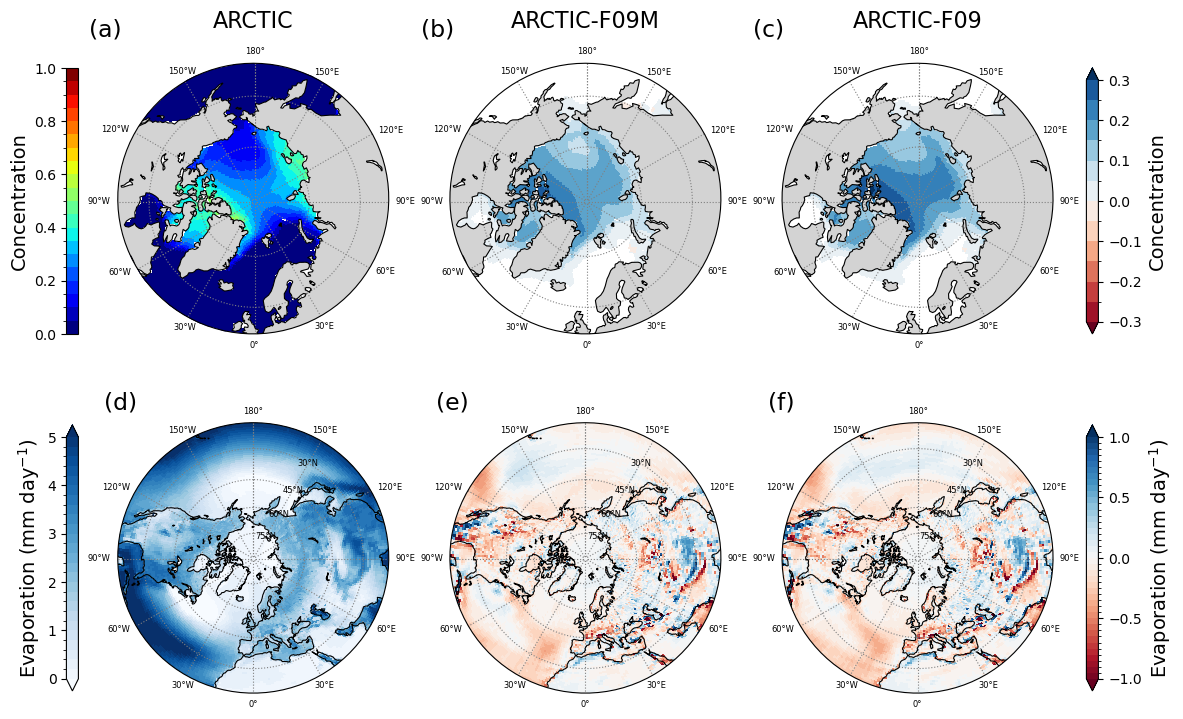

In [90]:
# Sea ice concentration and evaporation differences
fig = plt.figure(figsize = (12,14))
gs=GridSpec(3,3)
plt.rcParams['axes.titlepad']=14

# Modify values here
size_title = 16

cmap1 = plt.cm.jet
bounds1 = np.arange(0.,1.01,0.05)
bounds1min = [-5]
bounds1max = [5]
norm1 = colors.BoundaryNorm(bounds1, cmap1.N)#, extend='max')
ticks1 = np.arange(0.,1.01,0.2)

cmap2 = plt.cm.RdBu
bounds2 = np.arange(-0.3,0.31,0.05)
bounds2min = [-5]
bounds2max = [5]
norm2 = colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-0.3,0.31,0.1)

cmap3 = plt.cm.Blues
bounds3 = np.arange(0.,5.01,0.2)
bounds3min = [-50]
bounds3max = [50]
norm3 = colors.BoundaryNorm(bounds3, cmap3.N, extend='both')
ticks3 = np.arange(0.,5.01,1.)

cmap4 = plt.cm.RdBu
bounds4 = np.arange(-1.,1.01,0.05)
bounds4min = [-50]
bounds4max = [50]
norm4 = colors.BoundaryNorm(bounds4, cmap4.N, extend='both')
ticks4 = np.arange(-1.,1.01,0.5)

#=============line1===============
ax1 = plt.subplot(gs[0],projection=crs_ortho)
plot_arctic(ax1,50)
im1 = ax1.pcolormesh(lon, lat, ARCTIC_aice_div, transform=crs_ll, cmap=cmap1, norm=norm1)
ax1.set_title('ARCTIC', fontsize=size_title)#, weight='bold')
ax1.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax1.add_feature(cfeature.COASTLINE, zorder=3, lw=0.8)
ax1.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='white')
gl = ax1.gridlines(color='gray', lw=0.8, ls=':', crs=ccrs.PlateCarree(), draw_labels=True, rotate_labels=False)
gl.xlocator = mpl.ticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mpl.ticker.FixedLocator([-90, -75, -60, -30, 0, 30, 45, 60, 75, 90])
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}
plt.text(-5000000, 5000000, '(a)', fontsize=17)#, weight='bold')

# colorbar
cbar_ax1 = fig.add_axes([0.08, 0.655, 0.01, 0.19])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb1.set_label(label='Concentration', size=14)
cb1.ax.tick_params(labelsize=10)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

ax2 = plt.subplot(gs[1],projection=crs_ortho)
plot_arctic(ax2,50)
im2 = ax2.pcolormesh(lon, lat, ARCTIC_f09_aice_diff_div, transform=crs_ll, cmap=cmap2, norm=norm2)
#ax2.contourf(lon, lat, case21_22_sig_mam_change, transform=crs_ll, hatches=['..'], alpha=0)
ax2.set_title('ARCTIC-F09M', fontsize=size_title)#, weight='bold')
ax2.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax2.add_feature(cfeature.COASTLINE, zorder=3, lw=0.8)
ax2.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='white')
gl = ax2.gridlines(color='gray', lw=0.8, ls=':', crs=ccrs.PlateCarree(), draw_labels=True, rotate_labels=False)
gl.xlocator = mpl.ticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mpl.ticker.FixedLocator([-90, -75, -60, -30, 0, 30, 45, 60, 75, 90])
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}
plt.text(-5000000, 5000000, '(b)', fontsize=17)

ax3 = plt.subplot(gs[2],projection=crs_ortho)
plot_arctic(ax3,50)
im3 = ax3.pcolormesh(lon, lat, ARCTIC_f09_nohacks_aice_diff_div, transform=crs_ll, cmap=cmap2, norm=norm2)
#ax3.contourf(lon, lat, case31_32_sig_mam_change, transform=crs_ll, hatches=['..'], alpha=0)
ax3.set_title('ARCTIC-F09', fontsize=size_title)#, weight='bold')
ax3.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax3.add_feature(cfeature.COASTLINE, zorder=3, lw=0.8)
ax3.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='white')
gl = ax3.gridlines(color='gray', lw=0.8, ls=':', crs=ccrs.PlateCarree(), draw_labels=True, rotate_labels=False)
gl.xlocator = mpl.ticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mpl.ticker.FixedLocator([-90, -75, -60, -30, 0, 30, 45, 60, 75, 90])
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}
plt.text(-5000000, 5000000, '(c)', fontsize=17)

# colorbar
cbar_ax3 = fig.add_axes([0.93, 0.655, 0.01, 0.19])
cb3 = fig.colorbar(im3, cax=cbar_ax3, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
#cb3 = fig.colorbar(cm.ScalarMappable(norm=norm6, cmap=cmap6), cax=cbar_ax6, orientation='vertical', boundaries=bounds6min+bounds6+bounds6max, ticks=bounds6)
cb3.set_label(label='Concentration', size=14)
cb3.ax.tick_params(labelsize=10)

#=============line2===============
ax4 = plt.subplot(gs[3],projection=crs_np)
plot_arctic(ax4,20)
im4 = ax4.pcolormesh(f09_lon, f09_lat, ARCTIC_QFLX_JJA_div, transform=crs_ll, cmap=cmap3, norm=norm3)
ax4.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax4.add_feature(cfeature.COASTLINE, zorder=3, lw=0.8)
ax4.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='white')
gl = ax4.gridlines(color='gray', lw=0.8, ls=':', crs=ccrs.PlateCarree(), draw_labels=True, rotate_labels=False)
gl.xlocator = mpl.ticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mpl.ticker.FixedLocator([-90, -75, -60, -30, 0, 30, 45, 60, 75, 90])
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}
plt.text(-10000000, 10000000, '(d)', fontsize=17)#, weight='bold')

# colorbar
cbar_ax4 = fig.add_axes([0.08, 0.4, 0.01, 0.19])
cb4 = fig.colorbar(im4, cax=cbar_ax4, orientation='vertical', boundaries=bounds3min+bounds3+bounds3max, ticks=ticks3)
cb4.set_label(label='Evaporation (mm day$\mathregular{^{-1}}$)', size=14)
cb4.ax.tick_params(labelsize=10)
cb4.ax.yaxis.set_ticks_position('left')
cb4.ax.yaxis.set_label_position('left')

ax5 = plt.subplot(gs[4],projection=crs_np)
plot_arctic(ax5,20)
im5 = ax5.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_QFLX_JJA_diff_div, transform=crs_ll, cmap=cmap4, norm=norm4)
ax5.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax5.add_feature(cfeature.COASTLINE, zorder=3, lw=0.8)
ax5.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='white')
gl = ax5.gridlines(color='gray', lw=0.8, ls=':', crs=ccrs.PlateCarree(), draw_labels=True, rotate_labels=False)
gl.xlocator = mpl.ticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mpl.ticker.FixedLocator([-90, -75, -60, -30, 0, 30, 45, 60, 75, 90])
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}
plt.text(-11000000, 11000000, '(e)', fontsize=17)

ax6 = plt.subplot(gs[5],projection=crs_np)
plot_arctic(ax6,20)
im6 = ax6.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_nohacks_QFLX_JJA_diff_div, transform=crs_ll, cmap=cmap4, norm=norm4)
ax6.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax6.add_feature(cfeature.COASTLINE, zorder=3, lw=0.8)
ax6.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='white')
gl = ax6.gridlines(color='gray', lw=0.8, ls=':', crs=ccrs.PlateCarree(), draw_labels=True, rotate_labels=False)
gl.xlocator = mpl.ticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mpl.ticker.FixedLocator([-90, -75, -60, -30, 0, 30, 45, 60, 75, 90])
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}
plt.text(-11000000, 11000000, '(f)', fontsize=17)

# colorbar
cbar_ax6 = fig.add_axes([0.93, 0.4, 0.01, 0.19])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=bounds4min+bounds4+bounds4max, ticks=ticks4)
#cb6 = fig.colorbar(cm.ScalarMappable(norm=norm6, cmap=cmap6), cax=cbar_ax6, orientation='vertical', boundaries=bounds6min+bounds6+bounds6max, ticks=bounds6)
cb6.set_label(label='Evaporation (mm day$\mathregular{^{-1}}$)', size=14)
cb6.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    right=0.9,
                    #top=0.9,
                    wspace=0.25,
                    hspace=0.0)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_aice_evap_diff_div.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)